In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='d4a827d5-2ec3-4871-bef9-5357fb0800e6', project_access_token='p-a0b2f35beb25886a9e08926f749e55c766efea4b')
pc = project.project_context


# MARATÓN BEHIND THE CODE 2020

# DESAFÍO 8 - Digital House

El reto de Digital House tiene que ver con la misión y visión de la empresa; la cual busca transformar la vida de las personas, desarrollando competencias digitales, para que generen un impacto positivo en la sociedad. En ese sentido, Digital House busca a través de este desafío medir la empleabilidad de los cursos que disponibiliza en su plataforma, es decir que tan factible es que un alumno o egresado de Digital House acceda al mercado laboral o consiga un trabajo en su área luego de finalizar uno o varios de los cursos ofrecidos en la plataforma.

Entender que características o variables hacen que una persona sea más o menos empleable es fundamental para la empresa y para generar ese impacto positivo que busca aportar a la sociedad

<hr>

## Instalación de algunas bibliotecas de Python

In [2]:
!pip install scikit-learn --upgrade
!pip install scipy --upgrade

Requirement already up-to-date: scikit-learn in /opt/conda/envs/Python36/lib/python3.6/site-packages (0.23.2)
Requirement already up-to-date: scipy in /opt/conda/envs/Python36/lib/python3.6/site-packages (1.5.2)


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, Normalizer
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, AdaBoostClassifier,RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
import numpy as np

<hr>

## Descargue el conjunto de datos del desafío en formato .csv

In [4]:
import pandas as pd

!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/654986294958/master/train_dataset_digitalhouse.csv
df_training_dataset = pd.read_csv(r'train_dataset_digitalhouse.csv')
df_training_dataset.tail()

--2020-09-18 20:34:10--  https://raw.githubusercontent.com/vanderlei-test/654986294958/master/train_dataset_digitalhouse.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 654532 (639K) [text/plain]
Saving to: ‘train_dataset_digitalhouse.csv.5’

100%[======================================>] 654,532     --.-K/s   in 0.02s   

2020-09-18 20:34:10 (30.3 MB/s) - ‘train_dataset_digitalhouse.csv.5’ saved [654532/654532]



,Unnamed: 0,EDAD,GENERO,RESIDENCIA,NV_ESTUDIO,ESTUDIO_PREV,TRACK_DH,AVG_DH,MINUTES_DH,EXPERIENCIA,DIAS_EMP
8990,9995,29.0,MASCULINO,ARGENTINA,TERTIARY,DEVELOPMENT,NaN,4.0,4701.6,9.1,86.0
8991,9996,34.0,NaN,ARGENTINA,UNIVERSITARY,ENGINEERING,PROGRAMACION,3.4,4646.2,16.8,95.0
8992,9997,28.0,FEMENINO,ARGENTINA,POST_GRADUATE,ENGINEERING,EJECUTIVO,NaN,3315.1,5.6,95.0
8993,9998,23.0,MASCULINO,MEXICO,TERTIARY,ENGINEERING,PROGRAMACION,3.3,4437.8,0.9,87.0
8994,9999,36.0,MASCULINO,ARGENTINA,UNIVERSITARY,COMMERCIAL,DATA,3.4,4600.8,19.6,88.0


## En el conjunto de datos proporcionado, tenemos las siguientes columnas:

* Unnamed: 0
* EDAD
* GENERO
* RESIDENCIA
* NV_ESTUDIO
* ESTUDIO_PREV
* TRACK_DH
* AVG_DH
* MINUTES_DH
* EXPERIENCIA
* **DIAS_EMP = El valor "target" que se va a predecir**

Podemos verificar fácilmente que faltan valores usando el siguiente código:

```df_training_dataset.info()```

Debe manejar cuidadosamente estos valores faltantes antes de crear un modelo de regresión.

In [5]:
df_training_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8995 entries, 0 to 8994
Data columns (total 11 columns):
Unnamed: 0      8995 non-null int64
EDAD            7668 non-null float64
GENERO          7620 non-null object
RESIDENCIA      7638 non-null object
NV_ESTUDIO      7623 non-null object
ESTUDIO_PREV    7665 non-null object
TRACK_DH        7714 non-null object
AVG_DH          7651 non-null float64
MINUTES_DH      7619 non-null float64
EXPERIENCIA     7618 non-null float64
DIAS_EMP        8995 non-null float64
dtypes: float64(5), int64(1), object(5)
memory usage: 773.1+ KB


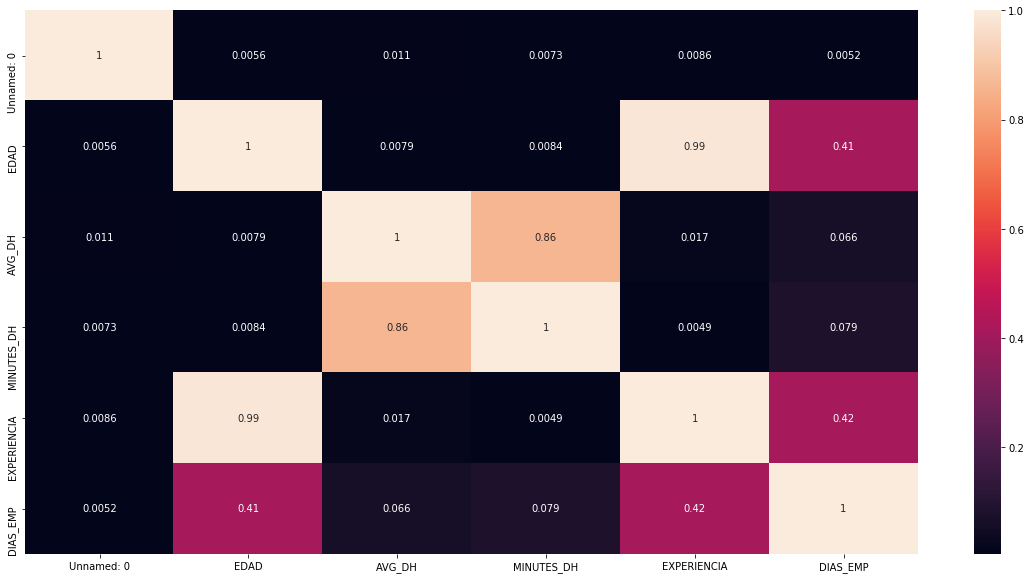

In [6]:
def graficar_correlaciones(df_temp):
    var_num = df_temp._get_numeric_data().columns.values.tolist()
    plt.figure(figsize = (20, 10))
    sns.heatmap(df_temp[var_num].corr().abs(), annot = True)
    
graficar_correlaciones(df_training_dataset)

In [7]:
def mostrar_correlaciones(df_temp):
    var_num = df_temp._get_numeric_data().columns.values.tolist()
    df_cols = df_temp[var_num].corr().stack().reset_index()
    df_cols.columns = ['VariableA','VariableB','correlation']
    df_corr = df_cols[(df_cols['correlation']>0.6)&(df_cols['correlation']!=1)]
    display(df_corr)
mostrar_correlaciones(df_training_dataset)

,VariableA,VariableB,correlation
10,EDAD,EXPERIENCIA,0.986745
15,AVG_DH,MINUTES_DH,0.863842
20,MINUTES_DH,AVG_DH,0.863842
25,EXPERIENCIA,EDAD,0.986745


In [8]:
semilla_aleatoria = 1234
umbral_categoria = 10
umbral_correlacion = 0.6
pd.options.display.max_columns=21
columna_target = 'DIAS_EMP'
categorias_target = []

In [9]:
def obtener_frecuencia_columnas(df_temp,columna_target):
    columnas_con_frecuencia = [] 
    categorias_target=[]
    for columna in df_temp.columns:    
        df_frecuencia_cat=df_temp.groupby([columna],as_index=False).size()        
        if len(df_frecuencia_cat)<umbral_categoria:
            if columna != columna_target:
                columnas_con_frecuencia.append(columna)
            else:
                for index, val in df_frecuencia_cat.iteritems():        
                    categorias_target.append(index)
            print(df_frecuencia_cat)
    return columnas_con_frecuencia, categorias_target
columnas_categoricas, categorias_target = obtener_frecuencia_columnas(df_training_dataset,columna_target)
print("Columnas con frecuencias: ",columnas_categoricas)
print("Categorias target: ",categorias_target)

GENERO
FEMENINO     2390
MASCULINO    5230
dtype: int64
RESIDENCIA
ARGENTINA    4843
BRAZIL       1667
MEXICO       1128
dtype: int64
NV_ESTUDIO
POST_GRADUATE     980
TERTIARY         1762
UNIVERSITARY     4881
dtype: int64
ESTUDIO_PREV
BUSINESS        203
COMMERCIAL     2077
DEVELOPMENT    1427
ENGINEERING    3850
MARKETING       108
dtype: int64
TRACK_DH
DATA            3464
EJECUTIVO        698
MARKETING        519
PROGRAMACION    3033
dtype: int64
Columnas con frecuencias:  ['GENERO', 'RESIDENCIA', 'NV_ESTUDIO', 'ESTUDIO_PREV', 'TRACK_DH']
Categorias target:  []


In [10]:
class DataFrameImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],index=X.columns)
        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [11]:
class DataLabelEncoderTransform(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X):
        return self
    
    def transform(self, X):    
        df_temp = X.copy()
        features = df_temp.columns.drop(self.columns)
        encoder = LabelEncoder()        
        df_encoder= df_temp[self.columns].apply(encoder.fit_transform)             
        return pd.concat([df_temp[features],df_encoder],axis=1)
    

In [12]:
columnas_numericas = df_training_dataset._get_numeric_data().columns.values.tolist()
columnas = df_training_dataset.columns.values.tolist()
columnas_no_numericas = [v for v in columnas if v not in columnas_numericas]
print(columnas_numericas)
print(columnas_no_numericas)

['Unnamed: 0', 'EDAD', 'AVG_DH', 'MINUTES_DH', 'EXPERIENCIA', 'DIAS_EMP']
['GENERO', 'RESIDENCIA', 'NV_ESTUDIO', 'ESTUDIO_PREV', 'TRACK_DH']


In [13]:
def graficar_carateristicas(df_temp,col_target):
    for feature in df_temp.columns.values:
        if feature != col_target:
            sns.jointplot(x=feature,y=col_target,data=df_temp,color='c')


<hr>

## Algunos consejos antes de entrenar a un modelo:

1. Manejar valores perdidos

2. Manejar variables categóricas

<hr>

## A continuación, le brindamos una plantilla simple para que sepa cómo estructurar las entradas y salidas de su modelo

### Removiendo columnas

In [14]:
columnas_eliminar = ['Unnamed: 0', 'EDAD','AVG_DH','MINUTES_DH']
df_training_dataset_1 = df_training_dataset.drop(columns=columnas_eliminar, inplace=False)
df_training_dataset_1.tail()

,GENERO,RESIDENCIA,NV_ESTUDIO,ESTUDIO_PREV,TRACK_DH,EXPERIENCIA,DIAS_EMP
8990,MASCULINO,ARGENTINA,TERTIARY,DEVELOPMENT,NaN,9.1,86.0
8991,NaN,ARGENTINA,UNIVERSITARY,ENGINEERING,PROGRAMACION,16.8,95.0
8992,FEMENINO,ARGENTINA,POST_GRADUATE,ENGINEERING,EJECUTIVO,5.6,95.0
8993,MASCULINO,MEXICO,TERTIARY,ENGINEERING,PROGRAMACION,0.9,87.0
8994,MASCULINO,ARGENTINA,UNIVERSITARY,COMMERCIAL,DATA,19.6,88.0


### Removendo valores NaN

In [15]:
df_training_dataset_2 = df_training_dataset_1.dropna()
df_training_dataset_2.tail()

,GENERO,RESIDENCIA,NV_ESTUDIO,ESTUDIO_PREV,TRACK_DH,EXPERIENCIA,DIAS_EMP
8984,FEMENINO,ARGENTINA,UNIVERSITARY,BUSINESS,PROGRAMACION,25.0,106.0
8988,MASCULINO,ARGENTINA,UNIVERSITARY,COMMERCIAL,DATA,20.9,86.0
8992,FEMENINO,ARGENTINA,POST_GRADUATE,ENGINEERING,EJECUTIVO,5.6,95.0
8993,MASCULINO,MEXICO,TERTIARY,ENGINEERING,PROGRAMACION,0.9,87.0
8994,MASCULINO,ARGENTINA,UNIVERSITARY,COMMERCIAL,DATA,19.6,88.0


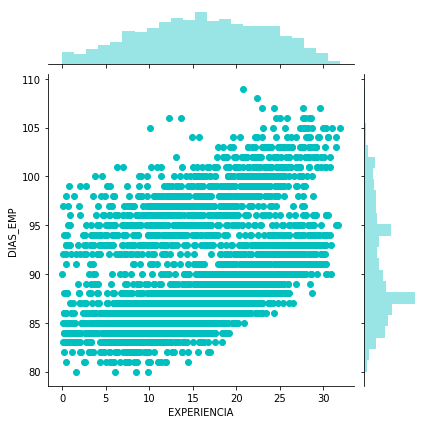

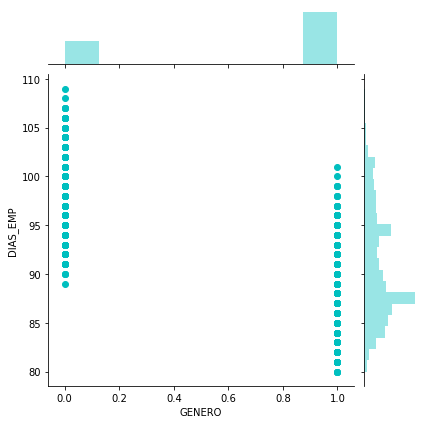

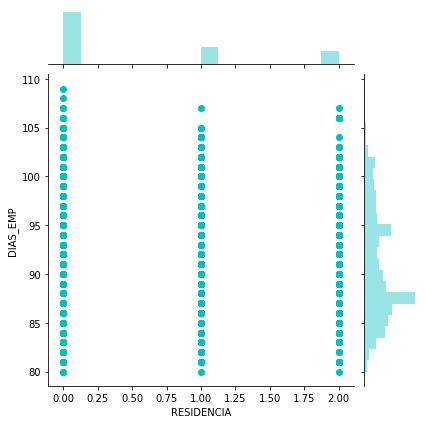

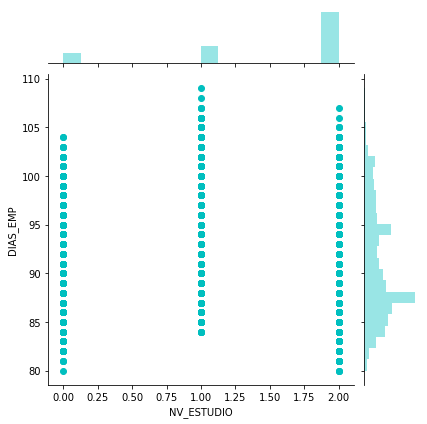

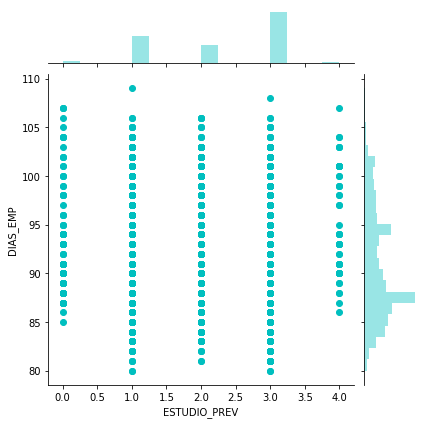

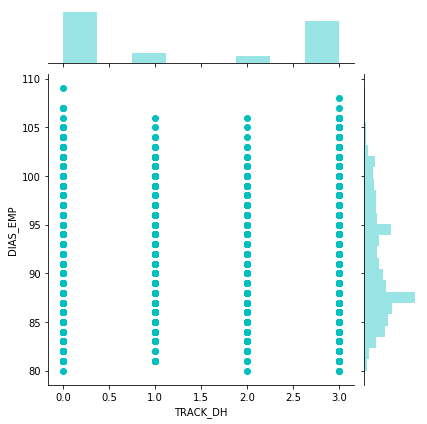

In [16]:
columnas_encoder =  [v for v in columnas_no_numericas if v not in [columna_target] ]
df3 = DataLabelEncoderTransform(columns=columnas_encoder).fit_transform(df_training_dataset_2)
graficar_carateristicas(df3,columna_target)

### Codificando variables categóricas

In [17]:
df4 = DataFrameImputer().fit_transform(df_training_dataset_2)

In [18]:
# Columnas One-hot-encoding del dataset usando el metodo de Pandas ``get_dummies`` (demontración)
columnas_dumies=['GENERO','RESIDENCIA','NV_ESTUDIO','ESTUDIO_PREV','TRACK_DH']
df_training_dataset_3 = pd.get_dummies(df4, columns=columnas_dumies)
df_training_dataset_3.tail()

,EXPERIENCIA,DIAS_EMP,GENERO_FEMENINO,GENERO_MASCULINO,RESIDENCIA_ARGENTINA,RESIDENCIA_BRAZIL,RESIDENCIA_MEXICO,NV_ESTUDIO_POST_GRADUATE,NV_ESTUDIO_TERTIARY,NV_ESTUDIO_UNIVERSITARY,ESTUDIO_PREV_BUSINESS,ESTUDIO_PREV_COMMERCIAL,ESTUDIO_PREV_DEVELOPMENT,ESTUDIO_PREV_ENGINEERING,ESTUDIO_PREV_MARKETING,TRACK_DH_DATA,TRACK_DH_EJECUTIVO,TRACK_DH_MARKETING,TRACK_DH_PROGRAMACION
8984,25.0,106.0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1
8988,20.9,86.0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0
8992,5.6,95.0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0
8993,0.9,87.0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1
8994,19.6,88.0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0


### Seleccionando las columnas "features" y "target"

In [19]:
df_training_dataset_3.columns

Index(['EXPERIENCIA', 'DIAS_EMP', 'GENERO_FEMENINO', 'GENERO_MASCULINO',
       'RESIDENCIA_ARGENTINA', 'RESIDENCIA_BRAZIL', 'RESIDENCIA_MEXICO',
       'NV_ESTUDIO_POST_GRADUATE', 'NV_ESTUDIO_TERTIARY',
       'NV_ESTUDIO_UNIVERSITARY', 'ESTUDIO_PREV_BUSINESS',
       'ESTUDIO_PREV_COMMERCIAL', 'ESTUDIO_PREV_DEVELOPMENT',
       'ESTUDIO_PREV_ENGINEERING', 'ESTUDIO_PREV_MARKETING', 'TRACK_DH_DATA',
       'TRACK_DH_EJECUTIVO', 'TRACK_DH_MARKETING', 'TRACK_DH_PROGRAMACION'],
      dtype='object')

In [20]:
columnas_modelo = [v for v in df_training_dataset_3.columns if v not in ['DIAS_EMP']]
print(columnas_modelo)
features = df_training_dataset_3[columnas_modelo
]

target = df_training_dataset_3['DIAS_EMP']  ## NO CAMBIE EL NOMBRE DE LA VARIABLE "target".

['EXPERIENCIA', 'GENERO_FEMENINO', 'GENERO_MASCULINO', 'RESIDENCIA_ARGENTINA', 'RESIDENCIA_BRAZIL', 'RESIDENCIA_MEXICO', 'NV_ESTUDIO_POST_GRADUATE', 'NV_ESTUDIO_TERTIARY', 'NV_ESTUDIO_UNIVERSITARY', 'ESTUDIO_PREV_BUSINESS', 'ESTUDIO_PREV_COMMERCIAL', 'ESTUDIO_PREV_DEVELOPMENT', 'ESTUDIO_PREV_ENGINEERING', 'ESTUDIO_PREV_MARKETING', 'TRACK_DH_DATA', 'TRACK_DH_EJECUTIVO', 'TRACK_DH_MARKETING', 'TRACK_DH_PROGRAMACION']


### Dividiendo el conjunto de datos para una "prueba ciega"

In [21]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=133)

### Entrenando un modelo de regresión lineal simple

In [22]:

class_SVC = SGDRegressor(max_iter=10000, tol=1e-100)
class_RNN = MLPRegressor(random_state=1, max_iter=15500)
class_RID = Ridge(alpha=0.00001,max_iter=8000)
class_RFO = RandomForestRegressor(n_estimators=1000, random_state=1)
regression_model = VotingRegressor(estimators=[('SVC', class_SVC), ('RID', class_RID),('RNN',class_RNN),('RFO',class_RFO)])
regression_model.fit(X_train,y_train)

VotingRegressor(estimators=[('SVC', SGDRegressor(max_iter=10000, tol=1e-100)),
                            ('RID', Ridge(alpha=1e-05, max_iter=8000)),
                            ('RNN',
                             MLPRegressor(max_iter=15500, random_state=1)),
                            ('RFO',
                             RandomForestRegressor(n_estimators=1000,
                                                   random_state=1))])

### Evaluando el modelo de regresión con el método  "score()" de sklearn

In [23]:
regression_model.score(X_test, y_test)

0.9196769079745062

<hr>

## Completar los datos necesarios para entregar la solución

### Como entrega de su solución, esperamos los resultados numéricos predichos por su modelo. Como entrada utilizará el archivo "to_be_scored.csv"

In [24]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/654986294958/master/to_be_scored_digitalhouse.csv
df_to_be_scored = pd.read_csv(r'to_be_scored_digitalhouse.csv')
df_to_be_scored.tail()

--2020-09-18 20:34:31--  https://raw.githubusercontent.com/vanderlei-test/654986294958/master/to_be_scored_digitalhouse.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67308 (66K) [text/plain]
Saving to: ‘to_be_scored_digitalhouse.csv.3’

100%[======================================>] 67,308      --.-K/s   in 0.004s  

2020-09-18 20:34:31 (17.8 MB/s) - ‘to_be_scored_digitalhouse.csv.3’ saved [67308/67308]



,Unnamed: 0,EDAD,GENERO,RESIDENCIA,NV_ESTUDIO,ESTUDIO_PREV,TRACK_DH,AVG_DH,MINUTES_DH,EXPERIENCIA,Unnamed: 10
995,995,33.0,MASCULINO,ARGENTINA,UNIVERSITARY,COMMERCIAL,PROGRAMACION,3.6,4576.5,15.1,NaN
996,996,40.0,MASCULINO,ARGENTINA,TERTIARY,COMMERCIAL,PROGRAMACION,3.4,4542.9,26.1,NaN
997,997,NaN,FEMENINO,ARGENTINA,UNIVERSITARY,ENGINEERING,DATA,3.4,NaN,27.4,NaN
998,998,NaN,MASCULINO,MEXICO,UNIVERSITARY,ENGINEERING,DATA,3.7,4730.4,1.1,NaN
999,999,36.0,NaN,ARGENTINA,UNIVERSITARY,NaN,PROGRAMACION,3.3,4506.5,20.4,NaN


# ¡Atención!

### El marco de datos ``to_be_scored`` es su "hoja de evaluación". Tenga en cuenta que la columna "target" no existe en esta muestra, por lo que no se puede utilizar para modelos de entrenamiento basados en el aprendizaje supervisado.

# ¡Atención!

### Debes realizar los mismos pasos de procesamiento previo que hiciste en el conjunto de datos de entrenamiento antes de calificar la "hoja de respuestas"

In [25]:
columnas_eliminar = ['Unnamed: 0','Unnamed: 10','EDAD','AVG_DH','MINUTES_DH']
df_to_be_scored_1 = df_to_be_scored.drop(columns=columnas_eliminar, inplace=False)
display(df_to_be_scored_1.info())
df_to_be_scored_2 = DataFrameImputer().fit_transform(df_to_be_scored_1)
display(df_to_be_scored_2.info())

df_to_be_scored_3 = pd.get_dummies(df_to_be_scored_2, columns=columnas_dumies)
df_to_be_scored_3.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
GENERO          868 non-null object
RESIDENCIA      831 non-null object
NV_ESTUDIO      858 non-null object
ESTUDIO_PREV    860 non-null object
TRACK_DH        847 non-null object
EXPERIENCIA     855 non-null float64
dtypes: float64(1), object(5)
memory usage: 47.0+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
GENERO          1000 non-null object
RESIDENCIA      1000 non-null object
NV_ESTUDIO      1000 non-null object
ESTUDIO_PREV    1000 non-null object
TRACK_DH        1000 non-null object
EXPERIENCIA     1000 non-null float64
dtypes: float64(1), object(5)
memory usage: 47.0+ KB


None

,EXPERIENCIA,GENERO_FEMENINO,GENERO_MASCULINO,RESIDENCIA_ARGENTINA,RESIDENCIA_BRAZIL,RESIDENCIA_MEXICO,NV_ESTUDIO_POST_GRADUATE,NV_ESTUDIO_TERTIARY,NV_ESTUDIO_UNIVERSITARY,ESTUDIO_PREV_BUSINESS,ESTUDIO_PREV_COMMERCIAL,ESTUDIO_PREV_DEVELOPMENT,ESTUDIO_PREV_ENGINEERING,ESTUDIO_PREV_MARKETING,TRACK_DH_DATA,TRACK_DH_EJECUTIVO,TRACK_DH_MARKETING,TRACK_DH_PROGRAMACION
995,15.1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1
996,26.1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1
997,27.4,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0
998,1.1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0
999,20.4,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1


In [26]:
df_to_be_scored_3.columns

Index(['EXPERIENCIA', 'GENERO_FEMENINO', 'GENERO_MASCULINO',
       'RESIDENCIA_ARGENTINA', 'RESIDENCIA_BRAZIL', 'RESIDENCIA_MEXICO',
       'NV_ESTUDIO_POST_GRADUATE', 'NV_ESTUDIO_TERTIARY',
       'NV_ESTUDIO_UNIVERSITARY', 'ESTUDIO_PREV_BUSINESS',
       'ESTUDIO_PREV_COMMERCIAL', 'ESTUDIO_PREV_DEVELOPMENT',
       'ESTUDIO_PREV_ENGINEERING', 'ESTUDIO_PREV_MARKETING', 'TRACK_DH_DATA',
       'TRACK_DH_EJECUTIVO', 'TRACK_DH_MARKETING', 'TRACK_DH_PROGRAMACION'],
      dtype='object')

<hr>

### Hacer las predicciones con el método "predict()" de sklearn y agregar los resultados en el marco de datos de la "hoja de evaluación"

In [27]:
y_pred = regression_model.predict(df_to_be_scored_3)
df_to_be_scored_3['target'] = y_pred
df_to_be_scored_3.tail()

,EXPERIENCIA,GENERO_FEMENINO,GENERO_MASCULINO,RESIDENCIA_ARGENTINA,RESIDENCIA_BRAZIL,RESIDENCIA_MEXICO,NV_ESTUDIO_POST_GRADUATE,NV_ESTUDIO_TERTIARY,NV_ESTUDIO_UNIVERSITARY,ESTUDIO_PREV_BUSINESS,ESTUDIO_PREV_COMMERCIAL,ESTUDIO_PREV_DEVELOPMENT,ESTUDIO_PREV_ENGINEERING,ESTUDIO_PREV_MARKETING,TRACK_DH_DATA,TRACK_DH_EJECUTIVO,TRACK_DH_MARKETING,TRACK_DH_PROGRAMACION,target
995,15.1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,86.220497
996,26.1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,93.017514
997,27.4,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,100.109797
998,1.1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,82.480418
999,20.4,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,87.696195


# ¡Atención!

### La columna agregada con los resultados debe llamarse "target", de lo contrario, su envío fallará.

<hr>

### Exportar el marco de datos de resultados como un archivo .csv a su proyecto de Watson Studio.

In [28]:
project.save_data(file_name="results.csv", data=df_to_be_scored_3.to_csv(index=False))

{'file_name': 'results.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'btcdes8-donotdelete-pr-ze2fwou3mtelup',
 'asset_id': '3f9ca0e7-3fd1-4082-a073-ab520d481f93'}